In [ ]:
import sys
sys.path.append("../src")

In [1]:
import logging, json
logging.basicConfig(format="%(asctime)s %(levelname)s - %(message)s", level=logging.INFO)

import pandas as pd
pd.set_option("display.min_rows", 4)
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

%reload_ext autoreload
%autoreload 2

from sapsam import parser, constants

2022-08-18 16:02:46,999 INFO - Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-18 16:02:47,000 INFO - NumExpr defaulting to 8 threads.


# CSV Format

The dataset is provided as a set of CSVs.

In [2]:
csv_paths = parser.get_csv_paths()

2022-08-18 16:02:48,708 INFO - Found 103 csvs


Let's parse the first rows of the first CSV.

In [3]:
csv_path = csv_paths[0]
print(csv_path.name)
df_raw = pd.read_csv(csv_path, nrows=5)
df_raw

0.csv


,Revision ID,Model ID,Organization ID,Datetime,Model JSON,Description,Name,Type,Namespace
0,5ed1535c95a342f4a414dd8c9b1b7df8,1ba74449e9354d0c9d4798b4a6e915d0,6c96d0b6e5e14eeaa9848f953a94e5f8,2019-03-19 11:36:50,"{""resourceId"": ""canvas"", ""properties"": {""name""...",NaN,Pivo,NaN,http://b3mn.org/stencilset/bpmn2.0#
1,301bfb5af53c431a830a6e435de6a590,1ba744cbcafb46c2a52482e36498a9bf,8af3fc1bb4b74e7c8c4089e4921d9056,2020-03-23 17:26:03,"{""resourceId"": ""canvas"", ""formats"": {""document...",NaN,Receipt of Application,NaN,http://b3mn.org/stencilset/bpmn2.0#
2,ac3baa3e59ca476396b4affa8e900c6f,1ba7587b3191422fb03a0e9ba92cebff,36fbc1ee23334e1ab987b07d2108eef2,2017-04-19 06:19:36,"{""resourceId"": ""canvas"", ""properties"": {""name""...",NaN,710 BPMN Conference room,NaN,http://b3mn.org/stencilset/bpmn2.0#
3,da11513a93224fbbb2c34ef9c5cfcaa9,1ba758f87e744ff0bcb3119887cac8cc,574093f96e5e4ff09a8b1f24eeb70284,2021-02-21 13:14:32,"{""resourceId"": ""canvas"", ""properties"": {""name""...",NaN,ECU application p,NaN,http://b3mn.org/stencilset/bpmn2.0#
4,70d06e82d8c344edab8b041f8b03161a,1ba77121c3be44d6bd0b354727f9707b,ff66cd6b779c44bba88ade8952d7e626,2020-06-30 07:12:48,"{""resourceId"": ""canvas"", ""properties"": {""name""...",NaN,2.9.1 Elektronischer Auftrag erfassen,NaN,http://b3mn.org/stencilset/bpmn2.0#


You can find a quick description of the columns in the `README.me` file of this repository.

Let's look at the model json format in more detail below.

In [4]:
model_json = json.loads(df_raw["Model JSON"][2])
print(model_json.keys())

dict_keys(['resourceId', 'properties', 'stencil', 'childShapes', 'bounds', 'stencilset', 'ssextensions', 'glossaryLinkRevisions'])


The root element of the model json represents the model itself. 

In [5]:
print("Root id:", model_json["resourceId"])
print("Root type:", model_json["stencil"]["id"])

Root id: canvas
Root type: BPMNDiagram


The most important part is the childShapes list. The childShapes is a recursive structure that can contain additional childShapes. For example, the elements of a pool are typically tracked as childShapes of the corresponding pool. 

In [6]:
from collections import defaultdict
from typing import Dict

def get_child_elements_by_category(element) -> Dict:
    cat_to_elements = defaultdict(list)
    for child in element["childShapes"]:
        category = child["stencil"]["id"]
        cat_to_elements[category].append(child)
    
    cat = element["stencil"]["id"]
    print("{} children category count: {}".format(cat, {k: len(v) for k,v in cat_to_elements.items()}))
    return cat_to_elements

root_child_dict = get_child_elements_by_category(model_json)

BPMNDiagram children category count: {'Pool': 1, 'SequenceFlow': 17}


Let's check out the first pool:

In [7]:
pool = root_child_dict["Pool"][0]
pool_child_dict = get_child_elements_by_category(pool)

Pool children category count: {'Lane': 3}


Now let's see which children each lane has:

In [8]:
for lane in pool_child_dict["Lane"]:
    get_child_elements_by_category(lane)

Lane children category count: {'Task': 2}
Lane children category count: {'Task': 8, 'Exclusive_Databased_Gateway': 2, 'EndNoneEvent': 1}
Lane children category count: {'StartNoneEvent': 1, 'Task': 2, 'EndNoneEvent': 1}


Let's look at the properties of the first lane element in more detail:

In [9]:
lane = pool_child_dict["Lane"][0]
shape = lane["childShapes"][0]
shape

{'resourceId': 'sid-652AF256-318D-40D9-9E1D-93877996929C',
 'properties': {'processid': '',
  'name': 'Inventory and Food Required',
  'documentation': '',
  'auditing': '',
  'monitoring': '',
  'flat': '',
  'categories': '',
  'startquantity': 1,
  'completionquantity': 1,
  'isforcompensation': False,
  'assignments': '',
  'callacitivity': False,
  'tasktype': 'None',
  'implementation': 'webService',
  'resources': '',
  'messageref': '',
  'operationref': '',
  'instantiate': False,
  'script': '',
  'scriptformat': '',
  'bgcolor': '#ffffcc',
  'looptype': 'None',
  'testbefore': False,
  'loopcondition': '',
  'loopmaximum': '',
  'loopcardinality': '',
  'loopdatainput': '',
  'loopdataoutput': '',
  'inputdataitem': '',
  'outputdataitem': '',
  'behavior': 'all',
  'complexbehaviordefinition': '',
  'completioncondition': '',
  'onebehavioreventref:': 'signal',
  'nonebehavioreventref': 'signal',
  'properties': '',
  'properties2': '',
  'datainputs': '',
  'dataoutputs': 

As can be seen, each shape has a lot of attributes, most of which are irrelevant for common use cases. Let us summarize the most important attributes:

In [10]:
print("Shape id:", shape["resourceId"])
print("Shape type:", shape["stencil"]["id"])
print("Label:", shape["properties"]["name"].replace("\n", "\\n"))
print("Bounding box:", shape["bounds"])
print("Outgoing:", shape["outgoing"])
print("Parent element:", lane["resourceId"])

Shape id: sid-652AF256-318D-40D9-9E1D-93877996929C
Shape type: Task
Label: Inventory and Food Required
Bounding box: {'lowerRight': {'x': 714, 'y': 116}, 'upperLeft': {'x': 614, 'y': 36}}
Outgoing: [{'resourceId': 'sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF'}]
Parent element: sid-A7ACCB17-82C8-4314-A762-F46070C31996


Parsing all the raw CSVs into one DataFrame uses a lot of memory and is rather slow. As the model json contains many attributes that are irrelevant for most uses cases, we provide a parser that only extracts the elements mentioned before, and returns a DataFrame with a row per model element. The parser only considers BPMN models, and can be used as a starting point to also develop parsers for other diagram types.

We showcase the parser in the `BPMN Model Elements` section.

# Model Metadata

Parsing the entire CSV with the "Model JSON" attribute consumes a lot of memory and is rather slow. We therefore provide a parser that ignores the "Model JSON" field and only parses the remaining model metadata columns. We also lower the column names and convert them to snake_case to make it more convenient to work with them in Pandas.

In [11]:
df_meta = parser.parse_model_metadata()
df_meta

2022-08-18 16:02:49,340 INFO - Found 103 csvs
2022-08-18 16:02:49,342 INFO - Starting to parse 103 cvs excluding model json
100%|███████████████████████████████████████████████████████████████████████████| 103/103 [04:26<00:00,  2.59s/it]
2022-08-18 16:07:16,445 INFO - Parsed 1021471 models


,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
1ba74449e9354d0c9d4798b4a6e915d0,5ed1535c95a342f4a414dd8c9b1b7df8,6c96d0b6e5e14eeaa9848f953a94e5f8,2019-03-19 11:36:50,NaN,Pivo,NaN,http://b3mn.org/stencilset/bpmn2.0#
1ba744cbcafb46c2a52482e36498a9bf,301bfb5af53c431a830a6e435de6a590,8af3fc1bb4b74e7c8c4089e4921d9056,2020-03-23 17:26:03,NaN,Receipt of Application,NaN,http://b3mn.org/stencilset/bpmn2.0#
...,...,...,...,...,...,...,...
18ca2c45cb824d06ae8573f0afb8813e,ace1037ddbbf4e91b03d60c0b6cf9162,359f2e98c56444b287a7818dc1a531b2,2018-01-13 12:23:47,NaN,2,NaN,http://b3mn.org/stencilset/bpmn2.0#
18ca2e80f3ff41a3a00dbce414c06506,8811500ae44f45e1befdcbd7b92e86da,096354c3fa3e4ec4a54a1b5297b46bc6,2018-12-01 18:17:11,NaN,Gyártáshoz szükséges cikk lekérdezése,NaN,http://b3mn.org/stencilset/epc#


The `df_meta` dataframe can be used to perform analysis on model level, e.g. to analyze the frequency of each modeling notation or to analyze the model names.

Here is an example that shows the distribution of the length of the model names:

,count,mean,std,min,25%,50%,75%,max
name,1021471.0,23.3,12.17,1.0,15.0,21.0,29.0,273.0


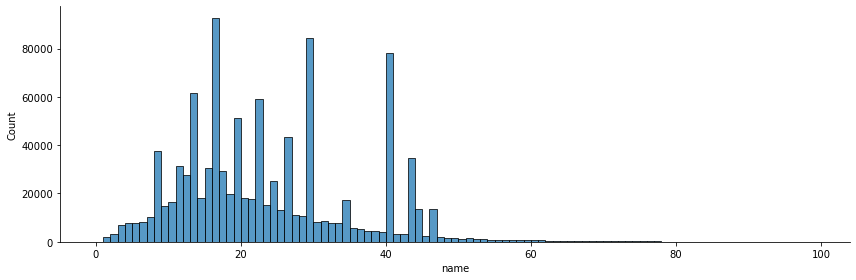

In [12]:
s_name_len = df_meta.name.map(lambda o: len(str(o)))
sns.displot(s_name_len, bins=np.arange(100), height=4, aspect=3);
s_name_len.describe().to_frame().T.round(2)

The sharp peaks might stem from the example processes that are added to each newly created workspace and might be worth further investigation. :-)

# BPMN Model Elements

As mentioned, we provide a BPMN model parser that returns a DataFrame with one row per model element.

In [13]:
p = parser.BpmnModelParser()
df = p.parse_model_elements()
df.head()

2022-08-18 16:07:18,229 INFO - Found 103 csvs
2022-08-18 16:07:18,230 INFO - Starting to parse 103 cvs
100%|███████████████████████████████████████████████████████████████████████████| 103/103 [35:19<00:00, 20.57s/it]


category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  
model_id                         element_id                                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                        
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                        
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262

Let's cache the DataFrame as a pickle file.

In [14]:
df.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl")

In other notebooks/code, this dataframe can then directly loaded with the reverse operation:
```python
df = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl")
```

The dataframe can be used to analyze various BPMN model aspects, such as the frequency of BPMN element types, the labels of the BPMN elements, and relational aspects that, e.g., analyze which elements often follow each other.
We provide some starter code for each use case below.

## BPMN constructs

We can group by `model_id` and then count the number of time each element type appears per model:

In [15]:
df_cnts = (
    df.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts

category,Association_Bidirectional,Association_Undirected,Association_Unidirectional,ChoreographyParticipant,ChoreographyTask,CollapsedEventSubprocess,CollapsedPool,CollapsedSubprocess,CollapsedVerticalPool,Communication,...,TextAnnotation,VerticalLane,VerticalPool,gdashedline,gdiamond,gdottedline,gellipse,grect,gtext,processparticipant
model_id,,,,,,,,,,,,,,,,,,,,,
0000150e890c45928d26584d491ada68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00001f477e9a4fb1b9dcb27e029a426d,0,2,3,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffff2b0eafa4ecca0b00fb5c6ccb4ef,0,2,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
ffffffd24864440a8effa3cdb9d37cce,0,8,2,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


Plot how often each element type appears in a model at least once:

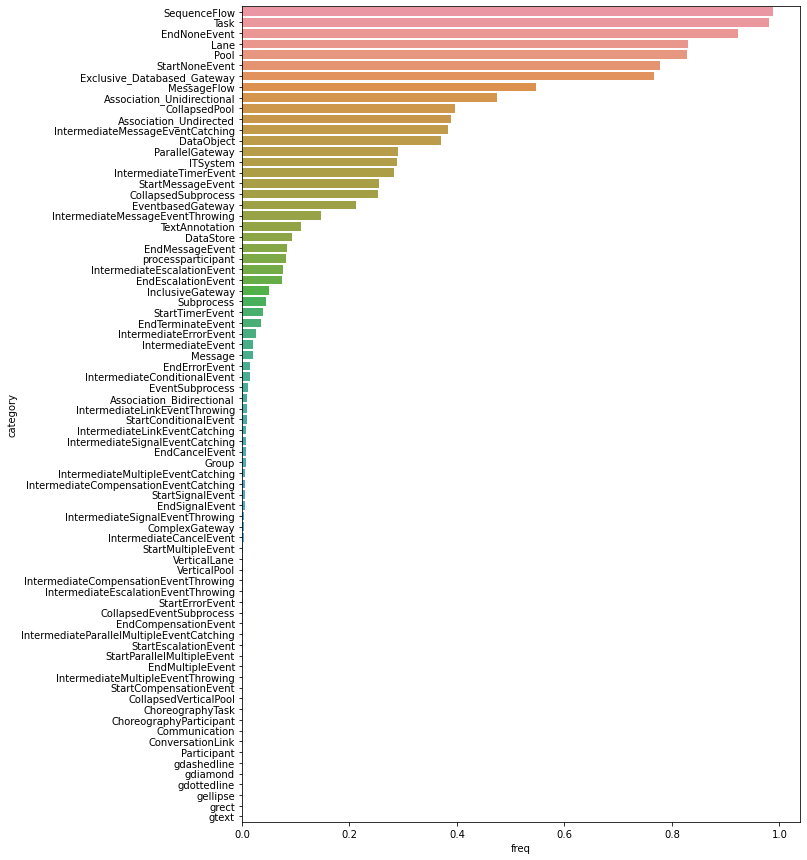

In [16]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    .div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("freq")
    .reset_index()
)

plt.figure(figsize=(10,15))
sns.barplot(x="freq", y="category", data=df_freq);

## BPMN labels

We can also analyze the labels of the model elements. Let's compute the length of each label:

In [17]:
df_lbl_len = df.label.fillna("").map(len).to_frame("lbl_len")
df_lbl_len

lbl_len
model_id                         element_id                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        0
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE        8
...                                                                            ...
18ca2c45cb824d06ae8573f0afb8813e sid-95E44D63-A1AA-46F8-966E-E28F326ED50A       15
                                 sid-6B8FC9F7-9A29-43F2-BE0B-D494F6275B8F       27

[28293762 rows x 1 columns]

Now let's check the maximum label length per model:

,count,mean,std,min,25%,50%,75%,max
lbl_len,605506.0,41.3,30.3,0.0,33.0,40.0,44.0,4043.0


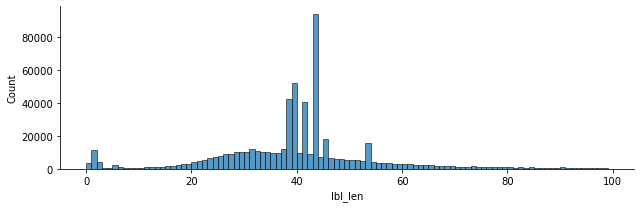

In [18]:
df_lbl_max_len = df_lbl_len.groupby("model_id").lbl_len.max()
sns.displot(df_lbl_max_len, bins=np.arange(100), height=3, aspect=3);
df_lbl_max_len.describe().to_frame().T.round(1)

Again, the peaks around 40 might stem from the high number of example processes present in the dataset.

## BPMN relations

The outgoing and parent attributes can be used to analyze the edges in the BPMN models and also hierarchical relations, such as how many elements a lane typically contains. The `BpmnModelParser` has two parameters that can be used to parse these attributes. As the resulting DataFrame for the entire dataset would consume a lot of memory, we only show the result when parsing the first CSV:

In [19]:
rel_parser = parser.BpmnModelParser(parse_outgoing=True, parse_parent=True)
df_rel = rel_parser.parse_model_elements(csv_paths=csv_paths[:1])
df_rel

2022-08-18 16:44:45,143 INFO - Starting to parse 1 cvs
100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.13s/it]


category  \
model_id                         element_id                                                 
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD     MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE            Pool   
...                                                                                   ...   
1e29cf037dde455f8cd83ebf1aa15cb9 sid-CD5BA5A2-D5AA-415E-818A-E934A4E2FFAD            Task   
                                 sid-626AA700-9D69-4045-88A0-AB3FBECAB0BF  StartNoneEvent   

                                                                                      label  \
model_id                         element_id                                                   
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                     
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE         Konobar\n   
...                                                                                     ...   
1e29cf037dde455f8cd83ebf1aa15cb9 sid-CD5BA5A2-D5AA-415E-818A-E934A4E2FFAD    GREET AND SEAT   
                                 sid-626AA700-9D69-4045-88A0-AB3FBECAB0BF  CUSTOMER ARRIVED   

                                                                           parent  \
model_id                         element_id                                         
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  canvas   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  canvas   
...                                                                           ...   
1e29cf037dde455f8cd83ebf1aa15cb9 sid-CD5BA5A2-D5AA-415E-818A-E934A4E2FFAD  canvas   
                                 sid-626AA700-9D69-4045-88A0-AB3FBECAB0BF  canvas   

                                                                                                             outgoing  
model_id                         element_id                                                                            
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  [sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246]  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE                                          []  
...                                                                                                               ...  
1e29cf037dde455f8cd83ebf1aa15cb9 sid-CD5BA5A2-D5AA-415E-818A-E934A4E2FFAD  [sid-75E11EA7-60E0-4C6E-919A-F1C511E61AD9]  
                                 sid-626AA700-9D69-4045-88A0-AB3FBECAB0BF  [sid-0AC8122D-1CFF-4777-B186-D2273EA8EF3D]  

[270885 rows x 4 columns]